# Feature selections to confrim the key features

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from collections import defaultdict


# 读取数据文件
data = pd.read_csv('/Users/xumoyan/Program/anaconda3/envs/cisc7201/final report/ML/dataset/train_data_encoded.csv')
# 检查列名（注意大小写和空格）
print("\n数据所有列名：")
print(data.columns.tolist())
print("读取数据后loan_status_flag的唯一值:", data['loan_status_flag'].unique())


数据所有列名：
['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_t

In [ ]:
grouped_features = {
    'home_ownership': [
        'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE',
        'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'
    ],
    'verification_status': [
        'verification_status_Not Verified',
        'verification_status_Source Verified',
        'verification_status_Verified'
    ],
    'earliest_cr_line': ['earliest_cr_line_year', 'earliest_cr_line_month']
}

# 所有特征（除目标列）
target_col = 'loan_status_flag'
all_features = [col for col in data.columns if col != target_col]

# 获取已分组的子特征 flat 列表
grouped_subfeatures = sum(grouped_features.values(), [])

# 找出剩下的特征（未被分组的）
ungrouped_features = [feat for feat in all_features if feat not in grouped_subfeatures]

# 将每个未分组特征作为单独的一组
for feat in ungrouped_features:
    grouped_features[feat] = [feat]

# 现在 grouped_features 就是 feature_groups
feature_groups = grouped_features

# ✅ 可视化检查
for group, feats in feature_groups.items():
    print(f"'{group}': {feats},")

# 处理特征和标签
if 'loan_status_flag' in data.columns:
    X = data.drop(['loan_status_flag'], axis=1, errors='ignore')
    y = data['loan_status_flag']
else:
    X = data.drop('loan_status', axis=1, errors='ignore')
    loan_status_flag = [
        'Charged Off', 'Default', 
        'Does not meet the credit policy. Status:Charged Off',
        'Late (31-120 days)'
    ]
    y = data['loan_status'].apply(lambda x: 1 if x in loan_status_flag else 0)

# 只保留数值特征
X = X.select_dtypes(include=[np.number])
print(f"处理后特征数量: {X.shape[1]}")




'home_ownership': ['home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT'],
'verification_status': ['verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified'],
'earliest_cr_line': ['earliest_cr_line_year', 'earliest_cr_line_month'],
'loan_amnt': ['loan_amnt'],
'funded_amnt': ['funded_amnt'],
'term': ['term'],
'int_rate': ['int_rate'],
'installment': ['installment'],
'sub_grade': ['sub_grade'],
'emp_length': ['emp_length'],
'annual_inc': ['annual_inc'],
'dti': ['dti'],
'delinq_2yrs': ['delinq_2yrs'],
'fico_range_low': ['fico_range_low'],
'fico_range_high': ['fico_range_high'],
'inq_last_6mths': ['inq_last_6mths'],
'mths_since_last_delinq': ['mths_since_last_delinq'],
'open_acc': ['open_acc'],
'pub_rec': ['pub_rec'],
'revol_bal': ['revol_bal'],
'revol_util': ['revol_util'],
'total_acc': ['total_acc'],
'initial_list_status': ['initial_list_status'],
'mths_si

# Method 1 ：过滤法

In [21]:
def get_original_feature_mapping():
    """建立衍生特征到原始特征的映射关系"""
    mapping = {
        # 日期衍生特征
        'earliest_cr_line_year': 'earliest_cr_line',
        'earliest_cr_line_month': 'earliest_cr_line',
        'last_credit_pull_d_year': 'last_credit_pull_d',
        'last_credit_pull_d_month': 'last_credit_pull_d',

        
        # One-Hot编码特征（前缀匹配）
        'home_ownership_': 'home_ownership',
        'verification_status_': 'verification_status',
        'purpose_': 'purpose',
        
        # 聚类衍生特征
        'emp_title_cluster': 'emp_title',
        'emp_title_cluster_freq': 'emp_title',
    }
    return mapping

# 按原始特征分组
def group_features_by_original(X, mapping):
    """将衍生特征按原始特征分组"""
    groups = {}
    # 先添加所有未映射的特征（原始特征）
    for col in X.columns:
        original = None
        # 精确匹配
        if col in mapping:
            original = mapping[col]
        # 前缀匹配（处理One-Hot编码特征）
        else:
            for prefix, orig in mapping.items():
                if prefix.endswith('_') and col.startswith(prefix):
                    original = orig
                    break
        # 未匹配的视为原始特征
        if original is None:
            original = col
            
        if original not in groups:
            groups[original] = []
        groups[original].append(col)
    return groups

# 处理特征和标签
if 'loan_status_flag' in data.columns:
    X = data.drop(['loan_status_flag'], axis=1, errors='ignore')
    y = data['loan_status_flag']
else:
    X = data.drop('loan_status', axis=1, errors='ignore')
    loan_status_flag = [
        'Charged Off', 'Default', 
        'Does not meet the credit policy. Status:Charged Off',
        'Late (31-120 days)'
    ]
    y = data['loan_status'].apply(lambda x: 1 if x in loan_status_flag else 0)

# 只保留数值特征
X = X.select_dtypes(include=[np.number])
print(f"处理后特征数量: {X.shape[1]}")


处理后特征数量: 88


<Axes: >

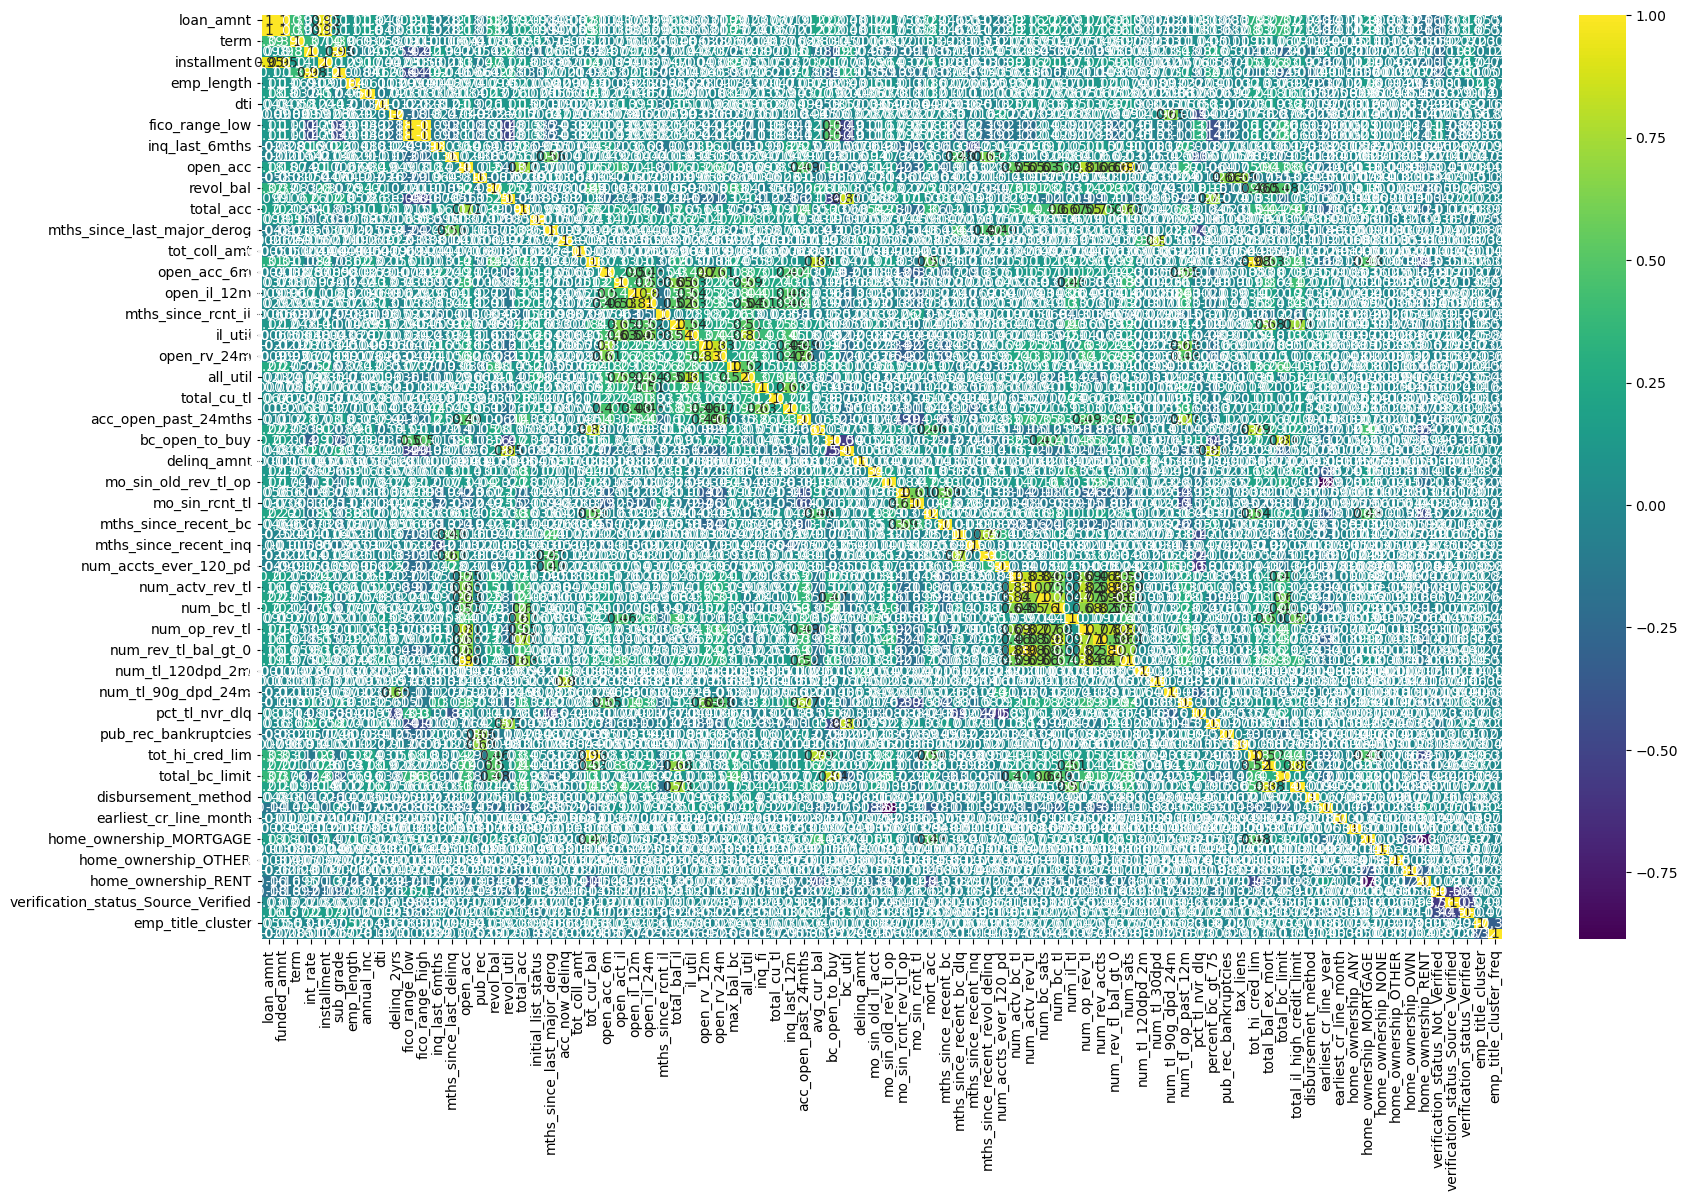

In [19]:
plt.figure(figsize=(20, 12))
sns.heatmap(X.corr(), annot=True, cmap='viridis')

In [48]:

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def filter_based_selection(X, y, feature_groups, select_percent=0.5):
    """按原始特征组进行过滤法选择，同时计算ANOVA和互信息两种评分，并取交集"""
    # 标准化特征（用于ANOVA）
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    # 初始化两组评分字典
    anova_group_scores = {}
    mi_group_scores = {}
    
    # 计算每个特征组的平均分数（ANOVA和互信息）
    for orig_feature, deriv_features in feature_groups.items():
        if not deriv_features:
            continue
        
        # 提取组内有效特征（确保特征存在于X中）
        valid_features = [f for f in deriv_features if f in X.columns]
        if not valid_features:
            anova_group_scores[orig_feature] = 0
            mi_group_scores[orig_feature] = 0
            continue
        

        # 计算ANOVA分数（基于标准化数据）
        try:
            f_scores = f_classif(X_scaled_df[valid_features], y)[0]
            # 仅处理NaN/Inf等异常值
            valid_f_scores = [score if not np.isnan(score) and not np.isinf(score) else 0 for score in f_scores]
            anova_group_scores[orig_feature] = np.mean(valid_f_scores)
        except:
            anova_group_scores[orig_feature] = 0
    

        # 计算互信息分数（基于原始数据，无需标准化）
        try:
            mi_scores = mutual_info_classif(X[valid_features], y, random_state=42)
            mi_group_scores[orig_feature] = np.mean(mi_scores)
        except:
            mi_group_scores[orig_feature] = 0
    
    # 按两种评分分别排序
    sorted_anova_groups = sorted(anova_group_scores.items(), key=lambda x: x[1], reverse=True)
    sorted_mi_groups = sorted(mi_group_scores.items(), key=lambda x: x[1], reverse=True)
    
    # 选择前select_percent%的特征组
    total_groups = len(feature_groups)
    k = max(1, int(total_groups * select_percent))  # 确保至少选择1个特征组
    
    top_anova_groups = [g[0] for g in sorted_anova_groups[:k]]
    top_mi_groups = [g[0] for g in sorted_mi_groups[:k]]
    
    # 计算两种方法的交集
    intersection_groups = list(set(top_anova_groups) & set(top_mi_groups))
    
    # 提取对应的特征列表
    top_anova_features = [f for g in top_anova_groups for f in feature_groups[g] if f in X.columns]
    top_mi_features = [f for g in top_mi_groups for f in feature_groups[g] if f in X.columns]
    intersection_features = [f for g in intersection_groups for f in feature_groups[g] if f in X.columns]
    
    # 可视化两种评分的top特征组
    plt.figure(figsize=(20, 8))
    
    # ANOVA结果可视化
    plt.subplot(1, 2, 1)
    anova_df = pd.DataFrame(sorted_anova_groups[:50], columns=['Original Feature', 'Avg ANOVA Score'])
    sns.barplot(x='Avg ANOVA Score', y='Original Feature', data=anova_df)
    plt.title('Top 50 Feature Groups by Average ANOVA Score')

    # 互信息结果可视化
    plt.subplot(1, 2, 2)
    mi_df = pd.DataFrame(sorted_mi_groups[:50], columns=['Original Feature', 'Avg MI Score'])
    sns.barplot(x='Avg MI Score', y='Original Feature', data=mi_df)
    plt.title('Top 50 Feature Groups by Average Mutual Information Score')
    
    plt.tight_layout()
    plt.savefig('feature_group_selection_filter.png', dpi=300)
    plt.close()
    
    print(f"ANOVA选择了 {len(top_anova_groups)} 个特征组，共 {len(top_anova_features)} 个特征")
    print(f"互信息选择了 {len(top_mi_groups)} 个特征组，共 {len(top_mi_features)} 个特征")
    print(f"交集选择了 {len(intersection_groups)} 个特征组，共 {len(intersection_features)} 个特征")
    
    return {
        'anova_top_groups': top_anova_groups,
        'anova_top_features': top_anova_features,
        'mi_top_groups': top_mi_groups,
        'mi_top_features': top_mi_features,
        'intersection_groups': intersection_groups,
        'intersection_features': intersection_features,  # 新增：交集特征
        'anova_group_scores': anova_group_scores,
        'mi_group_scores': mi_group_scores,
        'sorted_anova_groups': sorted_anova_groups,
        'sorted_mi_groups': sorted_mi_groups
    }

# 首先需要定义 feature_groups 变量，假设你已经有 feature_groups 字典
# 如果没有，请先定义 feature_groups

mapping = get_original_feature_mapping()
feature_groups = group_features_by_original(X, mapping)

# 运行过滤法特征选择（选择前50%的特征组）
filter_results = filter_based_selection(X, y, feature_groups, select_percent=0.5)

# 提取交集特征的数据（修正格式错误）
X_filter = X[filter_results['intersection_features']]
X_f = X[filter_results['mi_top_features']]
X_mi = X[filter_results['anova_top_features']]

ANOVA选择了 39 个特征组，共 46 个特征
互信息选择了 39 个特征组，共 48 个特征
交集选择了 20 个特征组，共 27 个特征


In [14]:
print(filter_results['intersection_features'])

['sub_grade', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'pub_rec_bankruptcies', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'acc_open_past_24mths', 'percent_bc_gt_75', 'mths_since_recent_inq', 'num_rev_tl_bal_gt_0', 'int_rate', 'fico_range_high', 'fico_range_low', 'num_tl_op_past_12m', 'mort_acc', 'num_actv_rev_tl', 'initial_list_status', 'term', 'inq_last_6mths', 'installment', 'mo_sin_rcnt_tl', 'open_act_il']


# Method 2: 随机森林

/Users/xumoyan/Program/anaconda3/envs/cisc7201/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:27:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 203438, number of negative: 1378498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8944
[LightGBM] [Info] Number of data points in the train set: 1581936, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128601 -> initscore=-1.913388
[LightGBM] [Info] Start training from score -1.913388


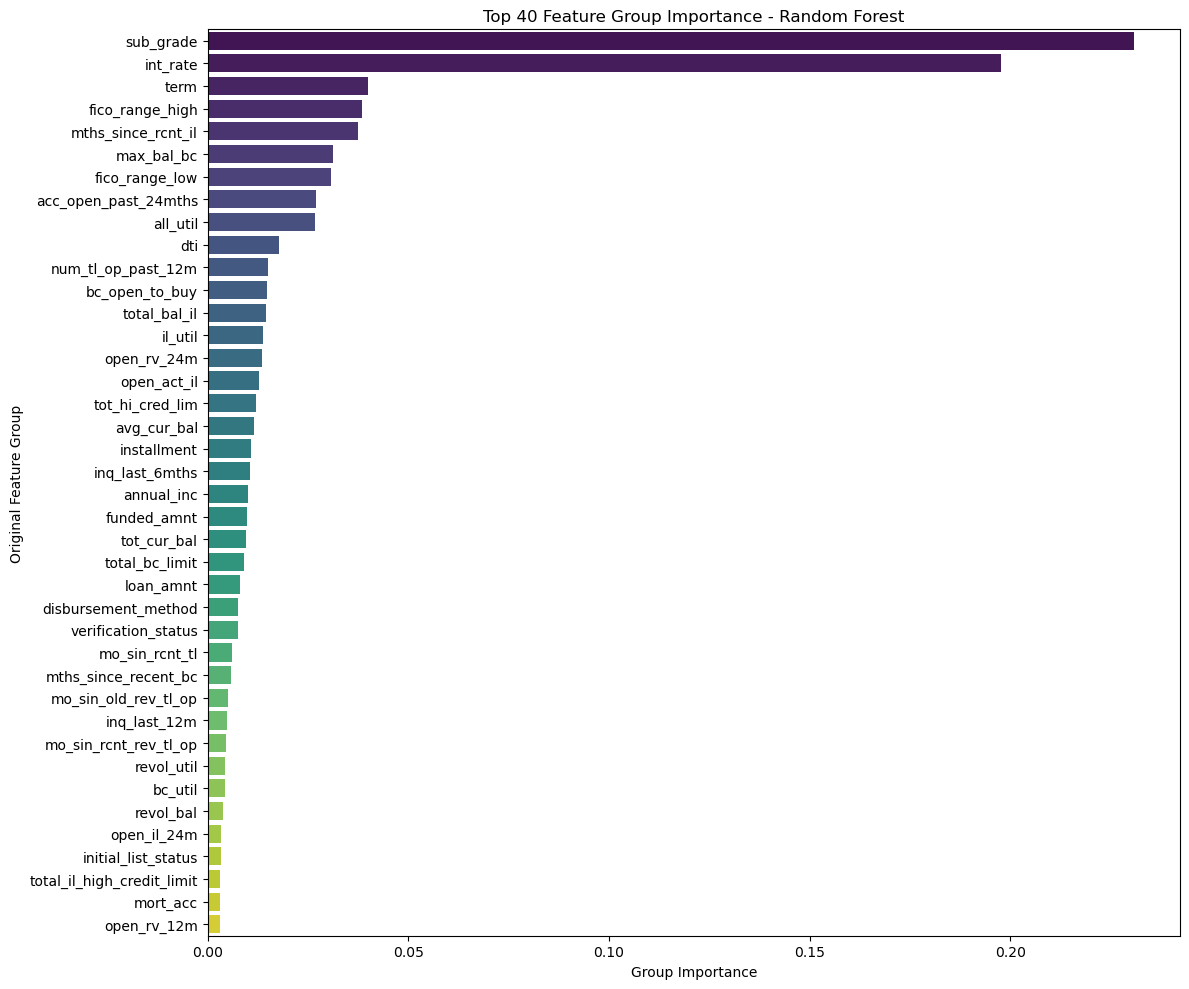

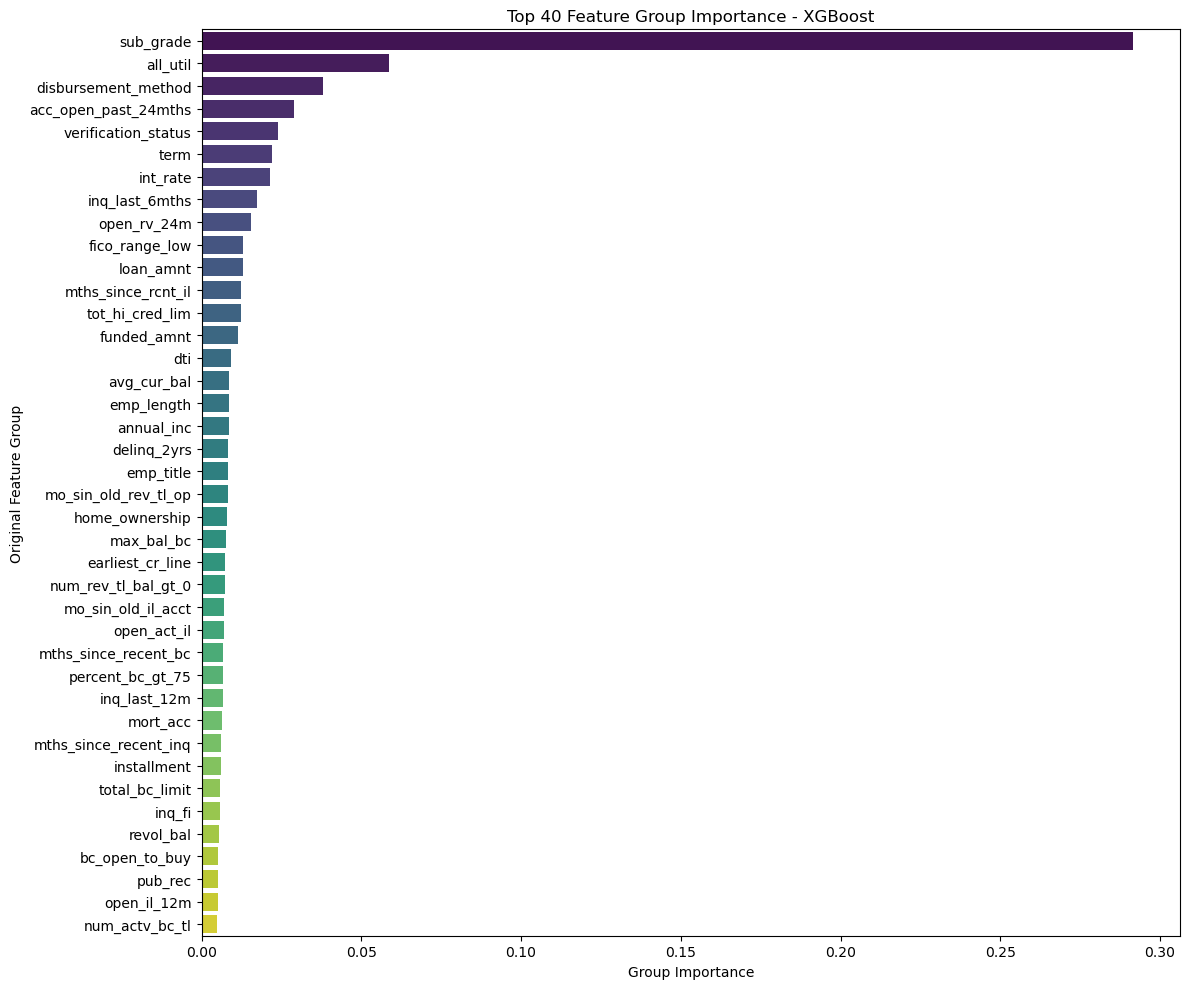

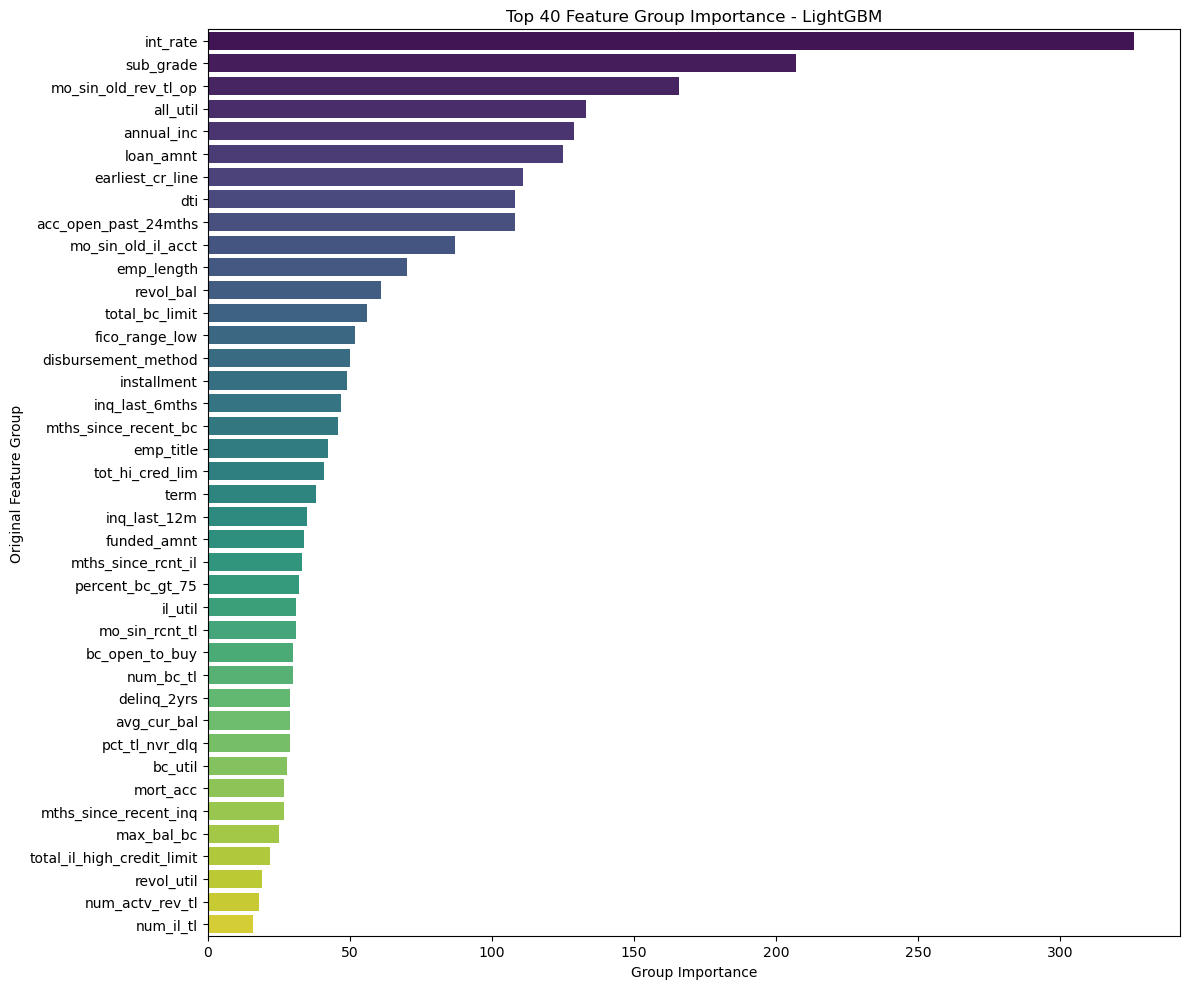

RandomForest 组重要性已保存至 RandomForest_group_importance.csv
RandomForest 单个特征重要性已保存至 RandomForest_individual_importance.csv

XGBoost 组重要性已保存至 XGBoost_group_importance.csv
XGBoost 单个特征重要性已保存至 XGBoost_individual_importance.csv

LightGBM 组重要性已保存至 LightGBM_group_importance.csv
LightGBM 单个特征重要性已保存至 LightGBM_individual_importance.csv



In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. 特征分组（复用方法一的逻辑）
mapping = get_original_feature_mapping()
feature_groups = group_features_by_original(X, mapping) 


# 2. 计算特征重要性（组和单个特征）
def compute_group_and_feature_importance(model, X, feature_groups):
    feature_importance = dict(zip(X.columns, model.feature_importances_))
    
    group_importance = {}
    for group_name, features in feature_groups.items():
        valid_features = [f for f in features if f in X.columns]
        if valid_features:
            group_importance[group_name] = np.mean([feature_importance[f] for f in valid_features])
        else:
            group_importance[group_name] = 0  
    
    return group_importance, feature_importance

# 随机森林
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)
group_importance_rf, feature_importance_rf = compute_group_and_feature_importance(rf, X, feature_groups)

# XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X, y)
group_importance_xgb, feature_importance_xgb = compute_group_and_feature_importance(xgb, X, feature_groups)

# LightGBM
lgb = LGBMClassifier(n_estimators=100, random_state=42)
lgb.fit(X, y)
group_importance_lgb, feature_importance_lgb = compute_group_and_feature_importance(lgb, X, feature_groups)

# 3. 筛选特征（修正：提取组内特征，而非组名）
top_n = 40  # 选择前40个特征组

# 随机森林（前40组特征）
# 1. 按重要性排序特征组，取前40组
top_groups_rf = sorted(group_importance_rf, key=group_importance_rf.get, reverse=True)[:top_n]
# 2. 收集这些组内的所有有效特征（存在于X中）
top_features_rf = []
for group in top_groups_rf:
    valid_features = [f for f in feature_groups[group] if f in X.columns]  # 只保留X中存在的特征
    top_features_rf.extend(valid_features)
# 3. 去重并提取特征
top_features_rf = list(set(top_features_rf))  # 避免重复特征
X_rf = X[top_features_rf]

# XGBoost（前40组特征）
top_groups_xgb = sorted(group_importance_xgb, key=group_importance_xgb.get, reverse=True)[:top_n]
top_features_xgb = []
for group in top_groups_xgb:
    valid_features = [f for f in feature_groups[group] if f in X.columns]
    top_features_xgb.extend(valid_features)
top_features_xgb = list(set(top_features_xgb))
X_xgb = X[top_features_xgb]

# LightGBM（前40组特征）
top_groups_lgb = sorted(group_importance_lgb, key=group_importance_lgb.get, reverse=True)[:top_n]
top_features_lgb = []
for group in top_groups_lgb:
    valid_features = [f for f in feature_groups[group] if f in X.columns]
    top_features_lgb.extend(valid_features)
top_features_lgb = list(set(top_features_lgb))
X_lgb = X[top_features_lgb]

# 4. 可视化特征组重要性（按组展示）
def plot_group_importance(group_importance, model_name, top_n=40):
    sorted_groups = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    group_names = [g[0] for g in sorted_groups]
    group_importances = [g[1] for g in sorted_groups]
    
    plt.figure(figsize=(12, 10))
    sns.barplot(
        x=group_importances, 
        y=group_names, 
        hue=group_names, 
        palette='viridis', 
        legend=False
    )
    plt.xlabel('Group Importance')
    plt.ylabel('Original Feature Group')
    plt.title(f'Top {top_n} Feature Group Importance - {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name}_group_importance.png', dpi=300)
    plt.show()

plot_group_importance(group_importance_rf, 'Random Forest', top_n=40)
plot_group_importance(group_importance_xgb, 'XGBoost', top_n=40)
plot_group_importance(group_importance_lgb, 'LightGBM', top_n=40)

# 5. 保存组重要性和单个特征重要性到CSV
def save_importance_results(model_name, group_importance, feature_importance):
    # 保存组重要性
    group_df = pd.DataFrame(
        sorted(group_importance.items(), key=lambda x: x[1], reverse=True),
        columns=['Original Feature Group', f'Average Importance ({model_name})']
    )
    group_df.to_csv(f'{model_name}_group_importance.csv', index=False)
    
    # 保存单个特征重要性
    feature_df = pd.DataFrame(
        sorted(feature_importance.items(), key=lambda x: x[1], reverse=True),
        columns=['Feature', f'Importance ({model_name})']
    )
    feature_df.to_csv(f'{model_name}_individual_importance.csv', index=False)
    
    print(f"{model_name} 组重要性已保存至 {model_name}_group_importance.csv")
    print(f"{model_name} 单个特征重要性已保存至 {model_name}_individual_importance.csv\n")

save_importance_results('RandomForest', group_importance_rf, feature_importance_rf)
save_importance_results('XGBoost', group_importance_xgb, feature_importance_xgb)
save_importance_results('LightGBM', group_importance_lgb, feature_importance_lgb)

# Method 3: REFC

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def wrapper_based_selection(X, y, feature_groups):
    estimator = LGBMClassifier(
        n_estimators=50,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    # 分层抽样
    sample_size = 10000
    if len(X) > sample_size:
        X_sample = X.sample(sample_size, random_state=42, stratify=y)
        y_sample = y.loc[X_sample.index]
        print(f"使用抽样数据（{sample_size}样本）加速计算")
    else:
        X_sample, y_sample = X, y
    
    # 递归特征消除
    rfecv = RFECV(
        estimator=estimator,
        step=1,
        cv=StratifiedKFold(5),
        scoring='roc_auc',
        min_features_to_select=5,
        n_jobs=-1
    )
    
    print(f"开始RFECV特征选择（初始特征数：{X_sample.shape[1]}）")
    rfecv.fit(X_sample, y_sample)
    
    # 获取选中的特征
    selected_features = X_sample.columns[rfecv.support_].tolist()
    
    # 可视化
    plt.figure(figsize=(12, 8))
    scores = rfecv.cv_results_['mean_test_score']
    plt.plot(range(1, len(scores) + 1), scores)
    plt.xlabel('Number of feature groups selected')
    plt.ylabel('ROC AUC')
    plt.title('Feature Group Selection with RFECV')
    plt.savefig('feature_group_selection_rfec.png')
    plt.close()
    
    return selected_features  # 直接返回特征列表

# 运行并获取RFE筛选的特征
X_rfe = wrapper_based_selection(X, y, feature_groups)



使用抽样数据（10000样本）加速计算
开始RFECV特征选择（初始特征数：88）
[LightGBM] [Info] Number of positive: 1029, number of negative: 6971
[LightGBM] [Info] Number of positive: 1029, number of negative: 6971
[LightGBM] [Info] Number of positive: 1029, number of negative: 6971
[LightGBM] [Info] Number of positive: 1029, number of negative: 6971
[LightGBM] [Info] Number of positive: 1028, number of negative: 6972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7627
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 84
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7615
[LightGBM] [Info] Number of data points in the train set: 8000, n

In [41]:
print(X_rfe)
print(len(X_rfe))

['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 

# Method 4: Lasso

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# 1. 对单个特征应用 L1 正则化
l1_selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=42)
)
X_l1 = l1_selector.fit_transform(X, y)

# 2. 提取选中的单个特征
selected_features = X.columns[l1_selector.get_support()].tolist()

# 3. 反向映射到特征组（保留包含选中特征的组）
selected_groups = set()
for f in selected_features:
    for group_name, deriv_features in feature_groups.items():
        if f in deriv_features:
            selected_groups.add(group_name)
            break

# 4. 输出结果
print(f"选中的单个特征数量：{len(selected_features)}")
print(f"对应的特征组数量：{len(selected_groups)}")
print(f"选中的特征组：{selected_groups}")

print(X_l1)

选中的单个特征数量：65
对应的特征组数量：61
选中的特征组：{'total_cu_tl', 'num_op_rev_tl', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'pct_tl_nvr_dlq', 'dti', 'sub_grade', 'il_util', 'open_rv_12m', 'mths_since_recent_revol_delinq', 'inq_last_12m', 'num_actv_bc_tl', 'verification_status', 'pub_rec_bankruptcies', 'num_bc_sats', 'emp_length', 'open_il_12m', 'home_ownership', 'revol_util', 'mths_since_last_major_derog', 'acc_open_past_24mths', 'num_bc_tl', 'mths_since_recent_inq', 'percent_bc_gt_75', 'num_sats', 'mths_since_last_delinq', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'funded_amnt', 'int_rate', 'mths_since_rcnt_il', 'open_rv_24m', 'disbursement_method', 'mo_sin_rcnt_rev_tl_op', 'fico_range_high', 'open_acc', 'fico_range_low', 'num_il_tl', 'delinq_2yrs', 'total_acc', 'inq_fi', 'num_tl_op_past_12m', 'mort_acc', 'open_acc_6m', 'num_actv_rev_tl', 'emp_title', 'open_il_24m', 'inq_last_6mths', 'term', 'initial_list_status', 'all_util', 'earliest_cr_line', 'installment', 'delinq_amnt', 'num_accts_ever_12

# 加权平均算法

In [43]:
# 新增函数：加权平均特征选择
def weighted_average_feature_selection(filter_results, X_rf, X_xgb, X_lgb, X_rfe, selected_features, weights):
 
    # 提取各方法选择的特征
    filter_features = filter_results['intersection_features']
    rf_features = X_rf.columns.tolist()
    xgb_features = X_xgb.columns.tolist()
    lgb_features = X_lgb.columns.tolist()
    
    # 合并所有特征
    all_features = set(filter_features + rf_features + xgb_features + lgb_features + X_rfe + selected_features)
    
    # 初始化特征得分字典
    feature_scores = {feat: 0 for feat in all_features}
    
    # 计算各特征的得分
    for feat in filter_features:
        feature_scores[feat] += weights['filter']
    for feat in rf_features:
        feature_scores[feat] += weights['rf']
    for feat in xgb_features:
        feature_scores[feat] += weights['xgb']
    for feat in lgb_features:
        feature_scores[feat] += weights['lgb']
    for feat in X_rfe:
        feature_scores[feat] += weights['rfe']
    for feat in selected_features:
        feature_scores[feat] += weights['lasso']
    
    # 按得分排序
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    
    # 选择得分最高的前50个特征
    selected = [feat for feat, score in sorted_features[:50]]
    
    return selected

# 定义各方法的权重
weights = {
    'filter': 0.2,
    'rf': 0.2,
    'xgb': 0.2,
    'lgb': 0.2,
    'rfe': 0.1,
    'lasso': 0.1
}

# 运行加权平均特征选择
X_weighted = weighted_average_feature_selection(filter_results, X_rf, X_xgb, X_lgb, X_rfe, selected_features, weights)

print(f"加权平均后选择的特征数量：{len(X_weighted)}")
print(f"加权平均后选择的特征：{X_weighted}")

加权平均后选择的特征数量：50
加权平均后选择的特征：['sub_grade', 'int_rate', 'fico_range_low', 'mort_acc', 'inq_last_6mths', 'acc_open_past_24mths', 'installment', 'term', 'dti', 'disbursement_method', 'inq_last_12m', 'funded_amnt', 'mths_since_rcnt_il', 'all_util', 'mo_sin_rcnt_tl', 'open_act_il', 'verification_status_Verified', 'mths_since_recent_bc', 'percent_bc_gt_75', 'mths_since_recent_inq', 'mo_sin_old_rev_tl_op', 'max_bal_bc', 'total_bc_limit', 'revol_bal', 'avg_cur_bal', 'tot_hi_cred_lim', 'loan_amnt', 'bc_open_to_buy', 'annual_inc', 'emp_title_cluster_freq', 'verification_status_Not_Verified', 'emp_title_cluster', 'num_rev_tl_bal_gt_0', 'delinq_2yrs', 'earliest_cr_line_month', 'bc_util', 'earliest_cr_line_year', 'home_ownership_MORTGAGE', 'il_util', 'emp_length', 'revol_util', 'open_rv_24m', 'home_ownership_OWN', 'initial_list_status', 'total_il_high_credit_limit', 'num_tl_op_past_12m', 'home_ownership_RENT', 'mo_sin_old_il_acct', 'fico_range_high', 'num_actv_rev_tl']


#保存所有方法的特征

In [49]:
import pickle
# 保存所有特征子集
feature_dict = {
    'ANOVA': X_f,
    'MI': X_mi,
    'Filter': X_filter,
    'RF': X_rf,
    'XGboost': X_xgb,
    'LightGBM': X_lgb,
    'RFE': X_rfe,
    'L1': X_l1,
    'WeightedAvg': X_weighted,  # 假设你有加权平均结果
    # 其他方法...
}

with open('selected_features.pkl', 'wb') as f:
    pickle.dump(feature_dict, f)

print("特征筛选结果已保存到 selected_features.pkl")

特征筛选结果已保存到 selected_features.pkl
